**Import Important Packages**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
import pickle
import os
import re
import random
random.seed(244)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Implement Model Class**

In [22]:
class AutoComplete:


  def __init__(self, ngram, k_smoothing=0):
    self._model_trained = False
    self.ngram = ngram
    self._model_dict = dict()
    self._k_smoothing = k_smoothing
    



  @property
  def ngram(self):
    return self._ngram


  @ngram.setter
  def ngram(self, ngram):
    if type(ngram) != int:
      raise ValueError('Number of Ngram must be of type int.')
    if ngram <= 0:
      raise ValueError('Number of Ngram must be positive.')
    if self._model_trained:
      print('Warning you must train the model again in the altered ngram')
    self._ngram = ngram
    


  def fit(self, train_data, min_word_freq=5):
    preprocessed_data, self._vocabulary_dict = self.NLP_data_preprocessing(train_data, self.ngram, min_word_freq)
    for row in preprocessed_data:
      for key in row:
        if self._model_dict.get(key[:-1]) == None:
          self._model_dict[key[:-1]] = dict()
        self._model_dict[key[:-1]][key[-1]] = self._model_dict.get(key[:-1]).get(key[-1], 0) + 1

    if self._k_smoothing != 0:
      for key in self._model_dict.keys():
        self._model_dict[key] = (self._model_dict.get(key, 0) + self._k_smoothing) / (self._k_smoothing*len(self._vocabulary_dict))

    self.model_trained = True


  
  def pred_current_word(self, sentence, n_words=5):
      n_similar_words = n_words // 3
      n_pred_words = n_words // 3
      pred_sentence, last_word = AutoComplete.extract_last_word(sentence)
      pred_words, found = self.pred_next_word(pred_sentence, n_pred_words)
      similar_words = AutoComplete.n_most_similar_words(last_word, list(self._vocabulary_dict), n_similar_words)
      n_correct_words = n_words - (n_similar_words + n_pred_words) if found else n_words - n_similar_words
      correct_words = self.get_corrections(last_word, self._vocabulary_dict, n_correct_words)
      if found :
        return set(correct_words + similar_words + pred_words)
      else:
        return set(correct_words + similar_words)



  def pred_next_word(self, sentence, n_words=5):
    if self.model_trained:
      found_key = False
      preprocessed_sentence = self.preprocessing_for_pred(sentence)[-1]
      if self._model_dict.get(preprocessed_sentence) != None:
        pred = AutoComplete.sort_dict(self._model_dict[preprocessed_sentence])
        found_key = True
      else:
        pred = self._vocabulary_dict
      return list(pred)[:n_words], found_key
                              
    else:
      raise RuntimeError('You must train model before prediction')



  def preprocessing_for_pred(self, row):
    tokenizer = RegexpTokenizer(r'\w+')
    row = row.lower()
    row = tokenizer.tokenize(row)
    row = ('<s> '*(self.ngram)).strip().split(' ') + row
    row = AutoComplete.replace_unk_words(self._vocabulary_dict, row)
    return list(ngrams(row, self.ngram))



  def save(self, path, model_name):
    with open(os.path.join(path, model_name+'.pkl'), 'wb') as fp:
      pickle.dump(self, fp)
    print('model saved successfully to file.')



  @staticmethod
  def load(path):
    with open(path, 'rb') as fp:
      model = pickle.load(fp)
    print('model loaded successfully.')
    return model



  @staticmethod
  def NLP_data_preprocessing(train_data, ngram, min_word_freq=5):
    preprocessed_data = []
    tokenizer = RegexpTokenizer(r'\w+')
    vocabulary_dict = AutoComplete.get_vocabulary_dict(train_data)
    vocabulary_dict_with_unk = AutoComplete.get_vocabulary_dict_with_unk(vocabulary_dict, min_word_freq)
    vocabulary_dict_with_unk_with_prob = AutoComplete.get_dict_prob(vocabulary_dict_with_unk)
    for row in train_data:

      row = row.lower()
      row = tokenizer.tokenize(row)
      row = ('<s> '*(ngram)).strip().split(' ') + row
      row.append('</s>')
      row = AutoComplete.replace_unk_words(vocabulary_dict_with_unk_with_prob, row)
      preprocessed_data.append(list(ngrams(row, ngram+1)))
            
    return preprocessed_data, vocabulary_dict_with_unk_with_prob



  @staticmethod
  def extract_last_word(sentence):
    sentence = sentence.strip()
    sentence = sentence.split(' ')
    last_word = sentence[-1]
    sentence.remove(last_word)
    sentence_without_last_word = ""
    for word in sentence:
      sentence_without_last_word += word + ' '
    sentence_without_last_word = sentence_without_last_word.strip()
    return sentence_without_last_word, last_word

  @staticmethod
  def get_vocabulary_dict(train_data):
    vocabulary_dict = dict()
    for row in train_data:
      row = row.lower()
      row = row.split(' ')
      for word in row:
        vocabulary_dict[word] = vocabulary_dict.get(word, 0) + 1


    sorted_vocabulary_dict = AutoComplete.sort_dict(vocabulary_dict)
    return sorted_vocabulary_dict


  @staticmethod
  def get_dict_prob(dict_):
    V = sum(dict_.values())
    for key in dict_.keys():
      dict_[key] = dict_.get(key, 0) / V

    return dict_



  @staticmethod
  def sort_dict(dict_):
    keys = list(dict_.keys())
    values = list(dict_.values())
    sorted_value_index = np.flip(np.argsort(values))
    sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
    return sorted_dict



  @staticmethod
  def get_vocabulary_dict_with_unk(vocabulary_dict, freq=5):
    vocabulary = list(vocabulary_dict.keys())
    for word in vocabulary:
      if vocabulary_dict.get(word) < freq and word != '<s>' and word != '</s>':
        vocabulary_dict['<unk>'] = vocabulary_dict.get('<unk>', 0) + vocabulary_dict.pop(word)

    return vocabulary_dict



  @staticmethod
  def replace_unk_words(vocabulary_dict, row):
    for index in range(len(row)):
      if row[index] not in vocabulary_dict.keys() and row[index] != '<s>' and row[index] != '</s>':
        row[index] = '<unk>'

    return row



  @staticmethod
  def n_most_similar_words(source, vocabulary_list, n=2):
    distance = np.array([])
    for target in vocabulary_list:
      distance =np.append(distance, AutoComplete.minimum_edit_distance(source, target))
    n_similar_indeces = distance.argsort()[:n]
    n_similar_vocabulary_list = []
    for index in n_similar_indeces:
      n_similar_vocabulary_list.append(vocabulary_list[index])

    return n_similar_vocabulary_list
     


  @staticmethod
  def minimum_edit_distance(source, target, case_sensitive=False):
    if not case_sensitive:
      source = source.lower()
      target = target.lower()
    insert_cost = 1
    delete_cost = 1
    source = '#' + source
    target = '#' + target
    distance_matrix = np.zeros((len(source), len(target)), int)
    for row in range(1,len(source)):
      distance_matrix[row][0] = distance_matrix[row-1][0] + delete_cost
    for col in range(1,len(target)):
      distance_matrix[0][col] = distance_matrix[0][col-1] + insert_cost
    for row in range(1,len(source)):
      for col in range(1,len(target)):
        replace_cost = 0 if source[row] == target[col] else 2
        distance_matrix[row][col] = min(distance_matrix[row][col-1] + delete_cost,
                                        distance_matrix[row-1][col] + insert_cost,
                                        distance_matrix[row-1][col-1] + replace_cost)
        
    return distance_matrix[len(source)-1][len(target)-1]



  @staticmethod
  def get_corrections(word, probs_dict, n=2):
    suggestions = AutoComplete.get_suggestions(word)
    n_best = []    
    best_words = {suggest:probs_dict.get(suggest, 0) for suggest in suggestions}
    n_best = AutoComplete.sort_dict(best_words)
    n_best = list(n_best.keys())[:n]
    return n_best



  @staticmethod
  def get_suggestions(word):
    suggestions = list(AutoComplete.edit_one_letter(word) or AutoComplete.edit_two_letters(word) or set(word)) 
    return suggestions



  @staticmethod
  def edit_two_letters(word, allow_switches = True):
    edit_two_set = set()
    edit_two_set = AutoComplete.edit_one_letter(word, allow_switches)
    for item in edit_two_set:
        edit_two_set = edit_two_set.union(AutoComplete.edit_one_letter(item, allow_switches))
            
    return set(edit_two_set)


  
  @staticmethod
  def edit_one_letter(word, allow_switches = True):
    edit_one_set = set()
    edit_one_set = AutoComplete.insert_letter(word)
    edit_one_set += AutoComplete.delete_letter(word)
    edit_one_set += AutoComplete.replace_letter(word)
    if allow_switches:
        edit_one_set += AutoComplete.switch_letter(word)
    
    return set(edit_one_set)


  @staticmethod
  def insert_letter(word):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_l = []
    split_l = []
    split_l = [(word[:i], word[i:]) for i in range(len(word)+1)]
    insert_l = [L + letters[i] + R for i in range(len(letters)) for L, R in split_l]
    return insert_l



  @staticmethod
  def replace_letter(word):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    replace_l = []
    split_l = []
    split_l = [(word[:i], word[i:]) for i in range(len(word)+1)]
    replace_set = set([L + letters[i] + R[1:] for i in range(len(letters)) 
                       for L, R in split_l if L + letters[i] + R[1:] not in word and R])
    replace_l = sorted(list(replace_set))
    return replace_l



  @staticmethod
  def switch_letter(word):
    switch_l = []
    split_l = []
    split_l = [(word[:i], word[i:]) for i in range(len(word)+1)]
    switch_l = [L + R[1] + R[0] + R[2:] for L, R in split_l if len(R)>1]
    return switch_l


  
  @staticmethod
  def delete_letter(word):
    delete_l = []
    split_l = []
    split_l = [(word[:i], word[i:]) for i in range(len(word)+1)]
    delete_l = [L + R[1:] for L, R in split_l if R]
    return  delete_l





**Load Data**

In [23]:
train_data = pd.read_csv('/content/drive/MyDrive/Datasets/NLP Auto Complete/train.csv')
train_data.head()

,Unnamed: 0,query,intent,category
0,4158,Play the Instrumental Study on Vimeo .,PlayMusic,2
1,6232,Is there any hail in Monterey Bay National Mar...,GetWeather,3
2,4002,Play some jpop on Google Music .,PlayMusic,2
3,4110,"Play the playlist, A Mis Ninos de 30 .",PlayMusic,2
4,6963,Will there be hail around Khao Phanom Bencha N...,GetWeather,3


**Show Some Data statistics**

In [24]:
intent_values = train_data['intent'].unique()
print(intent_values)

['PlayMusic' 'GetWeather' 'AddToPlaylist' 'RateBook' 'SearchCreativeWork'
 'SearchScreeningEvent' 'BookRestaurant']


In [25]:
intent_counts = [np.sum(train_data['intent'] == class_)/len(train_data) for class_ in intent_values]
print(intent_counts)

[0.14509576320371445, 0.14509576320371445, 0.14088798607080674, 0.14190365641323274, 0.141758560650029, 0.1421213000580383, 0.1431369704004643]


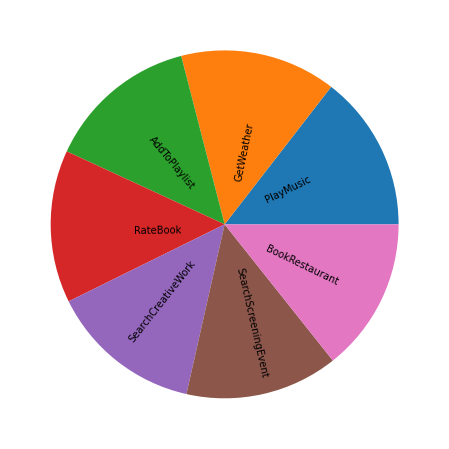

In [26]:
plt.figure(figsize=(8, 8))
#plt.hist(intent_counts, bins=intent_values)
plt.pie(intent_counts, labels=intent_values, labeldistance=0.25 ,rotatelabels=True)
plt.show()

**Define And Train The Model**

In [27]:
model = AutoComplete(2)
model.fit(train_data['query'], 1)

In [28]:
model._model_dict


{('<s>', '<s>'): {'play': 1685,
  'is': 421,
  'will': 413,
  'add': 1428,
  'rate': 869,
  'what': 1426,
  'i': 1671,
  'show': 496,
  'the': 97,
  'find': 1174,
  'book': 1003,
  'please': 298,
  'can': 381,
  'give': 465,
  'table': 12,
  'how': 95,
  'out': 8,
  'weather': 62,
  'where': 245,
  'need': 40,
  'when': 108,
  'use': 44,
  'list': 25,
  'go': 15,
  'make': 46,
  'search': 55,
  'therese': 1,
  'reserve': 25,
  'tell': 128,
  'for': 42,
  'turn': 4,
  'put': 180,
  'party': 4,
  'get': 26,
  'season': 1,
  'she': 11,
  'include': 17,
  'open': 42,
  'start': 5,
  'restaurant': 15,
  'bar': 1,
  'read': 6,
  'ethiopia': 1,
  'rat': 2,
  'look': 69,
  'this': 56,
  'want': 16,
  'stars': 1,
  'which': 39,
  'looking': 10,
  'forecast': 20,
  'during': 1,
  'diana': 1,
  'movie': 13,
  'download': 1,
  'forecase': 1,
  'listen': 10,
  'lets': 15,
  'programming': 1,
  'help': 11,
  'move': 3,
  'in': 35,
  'let': 22,
  'there': 5,
  'renee': 1,
  'on': 14,
  'coon': 1,
  '

In [29]:
model._vocabulary_dict

{'the': 0.05848672691998297,
 'a': 0.03459045095348507,
 'in': 0.027113992334263946,
 'to': 0.026798529945267276,
 'for': 0.024014574362371647,
 'of': 0.020221139134686667,
 'at': 0.01659332166122494,
 'play': 0.015086988753765832,
 'i': 0.014582248931371158,
 '.': 0.013872458556128646,
 'is': 0.012855092351614378,
 'book': 0.012697361157116043,
 'add': 0.012444991245918705,
 'find': 0.011064843294058265,
 'my': 0.011041183614883515,
 'what': 0.00952696414769949,
 'me': 0.009471758229625073,
 'on': 0.009369232953201155,
 'this': 0.009361346393476237,
 '6': 0.008896039369706147,
 'movie': 0.008754081294657644,
 'from': 0.008454392025110806,
 '?': 0.00832032050978722,
 'rate': 0.00792599252354138,
 'playlist': 0.00790233284436663,
 'and': 0.007444912380321456,
 'weather': 0.006940172557926781,
 'by': 0.006632596728655026,
 'be': 0.006506411773056358,
 'show': 0.006317134339658354,
 'give': 0.005891260114512847,
 'restaurant': 0.005843940756163346,
 'out': 0.005804507957538762,
 'will': 0

In [30]:
print(model.pred_current_word('play the Instru'))

{'intrus', 'Inwstru', 'Insptru', 'top', 'Inbtru'}


In [31]:
sant = "play"
while(True):
  pred, found = model.pred_next_word(sant)
  sant += ' ' + pred[0]
  sant = sant.strip()
  print(sant)
  if '</s>' in sant.split(' '):
    break

play the
play the top
play the top twenty
play the top twenty from
play the top twenty from tony
play the top twenty from tony calder
play the top twenty from tony calder off
play the top twenty from tony calder off slacker
play the top twenty from tony calder off slacker </s>


In [32]:
model._model_dict.get(('tv', 'series'))

{'the': 11,
 '</s>': 23,
 'rat': 1,
 'krieg': 1,
 'of': 2,
 'effortless': 1,
 'lego': 1,
 'titled': 3,
 'to': 1,
 'called': 15,
 'crossing': 1,
 'schedule': 1,
 'treeful': 1,
 'from': 1,
 'sailor': 1,
 'bet': 1,
 'shopping': 1,
 'truly': 1,
 'i': 1,
 'in': 1,
 'for': 1,
 'fast': 1,
 'strays': 1,
 'mothstorm': 1,
 '7even': 1,
 'shaun': 1,
 'heart': 1,
 'breed': 1,
 'box': 1,
 'polite': 1,
 'operace': 1,
 'liar': 1,
 'puppet': 1,
 'a': 2,
 'an': 1,
 'back': 1,
 'all': 1,
 'love': 1,
 'prescription': 1}

In [33]:
model._vocabulary_dict

{'the': 0.05848672691998297,
 'a': 0.03459045095348507,
 'in': 0.027113992334263946,
 'to': 0.026798529945267276,
 'for': 0.024014574362371647,
 'of': 0.020221139134686667,
 'at': 0.01659332166122494,
 'play': 0.015086988753765832,
 'i': 0.014582248931371158,
 '.': 0.013872458556128646,
 'is': 0.012855092351614378,
 'book': 0.012697361157116043,
 'add': 0.012444991245918705,
 'find': 0.011064843294058265,
 'my': 0.011041183614883515,
 'what': 0.00952696414769949,
 'me': 0.009471758229625073,
 'on': 0.009369232953201155,
 'this': 0.009361346393476237,
 '6': 0.008896039369706147,
 'movie': 0.008754081294657644,
 'from': 0.008454392025110806,
 '?': 0.00832032050978722,
 'rate': 0.00792599252354138,
 'playlist': 0.00790233284436663,
 'and': 0.007444912380321456,
 'weather': 0.006940172557926781,
 'by': 0.006632596728655026,
 'be': 0.006506411773056358,
 'show': 0.006317134339658354,
 'give': 0.005891260114512847,
 'restaurant': 0.005843940756163346,
 'out': 0.005804507957538762,
 'will': 0

In [34]:
model._vocabulary_dict.get(('play','the'))

In [35]:
AutoComplete.minimum_edit_distance('pla', '')

3

In [36]:
model.pred_next_word('play the')

(['top', 'album', 'song', 'most', 'greatest'], True)

In [37]:
model.save('/content/sample_data', 'model')

model saved successfully to file.


In [38]:
model2 = AutoComplete.load('/content/sample_data/model.pkl')

model loaded successfully.


In [39]:
model2._model_dict

{('<s>', '<s>'): {'play': 1685,
  'is': 421,
  'will': 413,
  'add': 1428,
  'rate': 869,
  'what': 1426,
  'i': 1671,
  'show': 496,
  'the': 97,
  'find': 1174,
  'book': 1003,
  'please': 298,
  'can': 381,
  'give': 465,
  'table': 12,
  'how': 95,
  'out': 8,
  'weather': 62,
  'where': 245,
  'need': 40,
  'when': 108,
  'use': 44,
  'list': 25,
  'go': 15,
  'make': 46,
  'search': 55,
  'therese': 1,
  'reserve': 25,
  'tell': 128,
  'for': 42,
  'turn': 4,
  'put': 180,
  'party': 4,
  'get': 26,
  'season': 1,
  'she': 11,
  'include': 17,
  'open': 42,
  'start': 5,
  'restaurant': 15,
  'bar': 1,
  'read': 6,
  'ethiopia': 1,
  'rat': 2,
  'look': 69,
  'this': 56,
  'want': 16,
  'stars': 1,
  'which': 39,
  'looking': 10,
  'forecast': 20,
  'during': 1,
  'diana': 1,
  'movie': 13,
  'download': 1,
  'forecase': 1,
  'listen': 10,
  'lets': 15,
  'programming': 1,
  'help': 11,
  'move': 3,
  'in': 35,
  'let': 22,
  'there': 5,
  'renee': 1,
  'on': 14,
  'coon': 1,
  '

In [ ]:
sentence = 'the'
while(True):
  words = input('enter your words: ')
  sentence += ' ' + words
  sentence = sentence.strip()
  print('if you want to complete last word press 1.')
  print('if you want to predict next word press 2.') 
  choice = int(input('enter your choice: '))

  if choice == 1:
    pred = model.pred_current_word(sentence)
  elif choice == 2:
    pred, found = model.pred_next_word(sentence)
  else:
    print('invalid choice')
    continue
  
  option = input('are you want to chose from predicted words y/n :')
  if(option.lower() == 'y'):
    print(pred)
    index = int(input('enter the number of word you want to choose: '))
    sentence += ' ' + pred[index-1]

  print(sentence)

  if '</s>' in sentence.split(' '):
    print('sentence is complete.')
    print('Thanks for using our program ^_^.')